<div style="display: block; width: 100%; height: 120px;">

<p style="float: left;">
    <span style="font-weight: bold; line-height: 24px; font-size: 16px;">
        DIGHUM160 - Critical Digital Humanities
        <br />
        Digital Hermeneutics 2020
    </span>
    <br >
    <span style="line-height: 22x; font-size: 14x; margin-top: 10px;">
        Week 5-3: Classification<br />
        Created by Tom van Nuenen (tom.van_nuenen@kcl.ac.uk)<br />
    </span>
</p>

#  Classification

This extended notebook introduces some common methods for **classification**.
Don't worry if you don't understand all of it – as long as you can see how classification might be valuable for your aims, that's enough!

First, we’ll be using a Naive Bayes Classifier to differentiate between different "classes" of data. We will look at some tools for sentiment analysis. Finally, we'll combine these two methods, so we can see if we can predict positive and negative texts.

After working through today's notebook, you will:

1. understand how to use a **Naive Bayes classifier** using Reddit data;
2. understand how to use a pre-trained sentiment analysis tool using **NLTK VADER**;
3. understand how to train a Naive Bayes classifier for a **supervised class of sentiments** (i.e., creating and training your own sentiment analysis tool).

Let's get started.


## Introduction to Naive Bayes classifiers

A Naive Bayes classifier is a machine learning algorithm that uses **Bayes’ Theorem** to predict the class that a sample belongs to, given a number of features that describe that sample. It is based on the concept of conditional probability: “What is the probability of our X, given Y?”. Which in our case is: "What is the probability of a post belonging to a category, given its word frequencies?" The math behind Bayes' Theorem is simple but intuitive. For more info, check out http://www.dealingdata.net/2016/07/24/PoGo-Series-NaiveBayesClassifier/.

Naive Bayes classifiers are often considered the baseline for classification tasks. They have worked quite well in many real-world situations, famously document classification and spam filtering. Mathematically speaking, they are very straightforward, you can use them when you have limited resources in terms of CPU and memory. Further, when the training time is a crucial factor, Naive Bayes comes handy since it can be trained very quickly. 

One peculiar aspect of Naive Bayes classifiers is that they assume that the features you use are *conditionally independent*: knowledge of the outcome of one feature does not grant us knowledge of the outcome of any other feature. When dealing with text, this means that we’re not looking at entire sentences, but rather at individual words. So for our purposes, “this was a fun party” is the same as “this party was fun” and “party fun was this”.

This is a pretty naive assumption (separate features are often correlated) — hence the name Naive Bayes Classifier. Yet, it turns out the algorithm often performs just as well than much more complex machine learning models.

In [34]:
# sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction import text
stop = text.ENGLISH_STOP_WORDS

# NLTK 
import nltk
from nltk import FreqDist
from nltk.classify import apply_features
from nltk.corpus import stopwords
from nltk.classify import accuracy
from nltk import NaiveBayesClassifier
from nltk.metrics import precision as prec
from nltk.metrics import recall as rec
from nltk.metrics import f_measure as fmeas
nltk.download('stopwords')
nltk.download('punkt') 

# pickle for saving
import pickle

# spacy for lemmatizing
import spacy

# VADER - installing using magic command `!pip install vaderSentiment` (command line script)
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Gensim's preprocessor
from gensim.utils import simple_preprocess

# General data science
import numpy as np
import re
import pandas as pd
import collections
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from IPython.display import clear_output

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Test using 20 Newsgroups

The 20 newsgroups dataset consists of around 18000 newsgroups posts on 20 topics. It's helpfully split in two subsets: one for training (i.e. development), and one for testing (i.e. performance evaluation). 

We will use a Naive Bayes classifier to **predict the topics of the posts in our test set**, based on the **word frequencies** in the posts in our training set. 

First, let's get the data. The `.target_names` method yields the topics that the newsgroups have been classified in.

In [ ]:
data = fetch_20newsgroups()

In [9]:
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Let's just get four of those to do our test with. We create a **training set** and a **test set**. The training set is, as the name implies, to train our classifier on. The test set we use to evaluate the performance of that classifier.

In [13]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

What does the data look like?


In [15]:
test.data[5]

"From: jsledd@ssdc.sas.upenn.edu (James Sledd)\nSubject: Re: Dreams and out of body incidents\nOrganization: Social Science Computing\nLines: 6\n\nIn article <May.14.02.10.02.1993.25119@athos.rutgers.edu> alisonjw@spider.co.uk (Alison J Wyld) writes:\n>From: alisonjw@spider.co.uk (Alison J Wyld)\n>PS. Just to make it clear, I don't do ( and have never tried ) OOBEs.\n>    I tend to think they are off limits for Christians.\n\nWHY?\n"

To convert the content of each string into a vector of numbers, we will use Scikit-learn's `TfidfVectorizer()` method again.

We're using sklearn's `MultinomialNB` as our classifier. **Multinomial Naive Bayes** is a specialized version of Naive Bayes that is specifically designed for text documents. Whereas *Simple Naive Bayes* would model a document as the presence and absence of particular words, *Multinomial Naive Bayes* explicitly models all the word counts and adjusts the underlying calculations. For more on the difference between these classifiers, see:
http://blog.datumbox.com/machine-learning-tutorial-the-naive-bayes-text-classifier/ 

Scikit-klearn allows us to create a **pipeline** using `make_pipeline()`, which attaches this vectorizer to a multinomial naive Bayes classifier (meaning we don't have to instantiate these methods separately).

In [16]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

### Fitting the data

With this pipeline, we can apply the model to the training data, and then predict labels for the test data:

In [17]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

In [18]:
labels[:5]

array([2, 0, 1, 0, 1])

Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator. For example, here is the confusion matrix between the true and predicted labels for the test data:

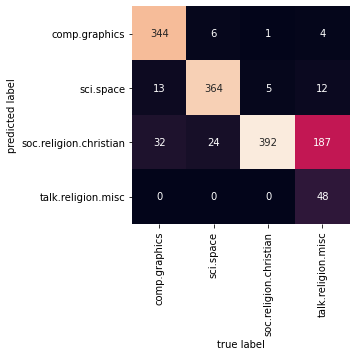

In [19]:
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Evidently, even this very simple classifier based on tf-idf scores can successfully separate posts about space from posts about computers. It gets confused, however, between talk about religion and talk about Christianity – an expected area of confusion.


### Prediction
With this classifier, we can now determine the category for any string, using the `predict()` method of this pipeline. Let's write a utility function that will return the prediction for a single string:

In [20]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [21]:
predict_category('Scientists discover new moon around Saturn')

'sci.space'

It works!

**Remember:** this is nothing more than a simple probability model for the (weighted) frequency of each word in the string! Nevertheless, the result is striking. Even a very naive algorithm, when used carefully and trained on a large set of high-dimensional data, can be surprisingly effective.

## Classification on r/amitheasshole

We will now use the same technique on a subreddit. We'll be using the subreddit r/amitheasshole: a subreddit in which members can vote whether an original poster [OP], in some social interaction, behaved "assholeish". 

### Preprocessing

We'll start by cleaning up our data a bit. Let's load it up.

In [187]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [188]:
downloaded = drive.CreateFile({'id':"1OGjtSWvPKmDseWQuzWA2EfoX_41ohhGo"})   
downloaded.GetContentFile('amita-submissions.csv')

In [60]:
# load into df
df = pd.read_csv("amita-submissions.csv", lineterminator='\n', encoding="utf8")[:20000]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [61]:
# clean up empty entries
df = df.drop(['augmented_at', 'augmented_count', 'distinguish'], axis=1)
df = df[~df['selftext'].isin(['[removed]', '[deleted]' ])].dropna(subset=['selftext'])
len(df)

16267

**Note:** if working with this entire dataset is still taking too long, consider using a slice.

In [28]:
df.head()

,idint,idstr,created,self,nsfw,author,title,url,selftext,score,subreddit,textlen,num_comments,flair_text,flair_css_class,selftext_clean
0,87247149,t3_1fy0bx,1370724175,1,0,flignir,AItA: I like air conditioning and my coworkers...,NaN,I work in an office that requires me to wear a...,2,AmItheAsshole,1067,1,not the asshole,not,I work in an office that requires me to wear a...
1,118961390,t3_1ytr72,1393275159,1,0,Irishman_reddit,[AITA] Construction worker here,NaN,I have been on a parking structure project for...,63,AmItheAsshole,565,9,too close to call,NaN,I have been on a parking structure project for...
2,118969807,t3_1ytxov,1393278651,1,0,Bobsmit,[AITA] I wrote an explanation in TIL and came ...,NaN,[Here is the post in question](http://www.redd...,51,AmItheAsshole,510,13,asshole,ass,Here is the post in question http www.reddit.c...
3,118975728,t3_1yu29c,1393281184,1,0,WoopAhhh,[AITA] Threw my parent's donuts away,NaN,"My parents are diabetic, morbidly obese, and a...",142,AmItheAsshole,735,27,asshole,ass,My parents are diabetic morbidly obese and add...
4,118978034,t3_1yu41e,1393282238,1,0,ThisIsMeYoRightHere,[AITA] I Put My Empty Beer on a Bar Table,NaN,"Relevant Facts:\n\n1) It was a crowded bar, th...",46,AmItheAsshole,660,7,nothing happened,NaN,Relevant Facts It was a crowded bar the table ...


We can clean up some of the text in our DataFrame using a function which we `apply()` to the selftext column.

In [67]:
def clean_text(text):
  # Normalize tabs and remove newlines
  no_tabs = text.replace('\t', ' ').replace('\n', '');
  # Remove all characters except A-Z and a dot.
  alphas_only = re.sub("[^a-zA-Z\.]", " ", no_tabs);
  # Normalize spaces to 1
  multi_spaces = re.sub(" +", " ", alphas_only);
  # Strip trailing and leading spaces
  no_spaces = multi_spaces.strip();
  return no_spaces

df["selftext_clean"] = df["selftext"].apply(lambda x: clean_text(x))

### A classifier for assholes?

Now that we've seen how classification works, let's write a classifier for this subreddit. A typical use of this would be, for instance, to classify which particular subreddit a post belongs to. Or to classify posts that should be categorized as "NSFW".

But you can also use classification to test out certain hypotheses: for instance, can we predict whether a post will be classified as "ITA" (*Is The Asshole*), given its textual features?

Luckily, the members of r/amitheasshole have done some work for us by labeling the posts. We can use these labels to train our classifier. Let's have a look at the `flair_css_class` column in our DataFrame.

In [62]:
df['flair_css_class'].value_counts()

not         8893
ass         3352
shitpost      55
Name: flair_css_class, dtype: int64

Looks like the `flair_css_class` column contains lots of tags for asshole and non-asshole posts. Let's use this column for now. We'll remove anything that's *not* classified as `not` or `ass`.

In [63]:
df = df[~df['flair_css_class'].isin(['shitpost', '1' ])].dropna(subset=['flair_css_class'])
len(df)

12245

The next issue is that we have an unbalanced classification: "Not the Asshole" (`not`) posts occur over double as many times as "Asshole" (`ass`). We can choose to either **upsample** our "Asshole" category (by adding doubles) or **downsampling** our "Not the A-hole" category by removing entries. You ideally have to try both, as what works best differs from case to case, but let's downsample for now. 

First, we want our DataFrame sorted. Then, we create a boolean mask for the negative values, use `np.where` to get the indices of these rows, `drop` these indices, then drop one half of those indices:

In [116]:
# Sorting the values
df.sort_values('flair_css_class', inplace=True)

# creating a mask for the condition
mask = (df.flair_css_class == "not")

# find out which indexes this condition refers to using np.where()
idx, = np.where(mask)

# divide by 2 and drop the indices
df.drop(df.index[idx[:len(idx)//2]], inplace=True)

Let's see how many entries for our classes we have now.


In [117]:
df['flair_css_class'].value_counts()

ass    3352
not    2965
Name: flair_css_class, dtype: int64

Looks more balanced now!

Next, let's work on our input features. We'll start by lemmatizing and POS-filtering our texts. We'll output strings for each post which we can then load into our vectorizer.

In [137]:
nlp = spacy.load('en', disable=['parser', 'ner'])
stop = set(stopwords.words('english') + ['’', '“', '”', 'nbsp', 'http', 'edit'])

def lemmatization(texts, allowed_postags=['NOUN', 'VERB', 'ADJ', 'ADV']):
    """https://spacy.io/api/annotation"""
    out = []
    for text in texts:
        doc = nlp(text) 
        stop_out = [token for token in doc if token not in stop]
        out.append(' '.join([token.lemma_ for token in stop_out if token.pos_ in allowed_postags]))
    return out

In [138]:
lemmas = lemmatization(df.selftext_clean)

In [139]:
lemmas[:10]

['s again sometimes trouble judge situation so sub really helpful roommate ask credit card car pay online come back in talk while conversation turn weather tell hear go snow today most tomorrow reply tell m wrong s just go flurry tell s just hear reply again tell s grandpa say wouldn wrong watch news so know hell s talk tell s defensive tell fuck room think need different roommate asshole',
 'so background m university program give strong background exercise exercise prescription movement cue other gym relate stuff also haven regularly exercise year ve been try fit again cardio intramural soccer hit gym when come gym cognitively know how correct movement other skill personal trainer may can t most exercise beginn level importantly personal trainer however so tonight work friend mine see study start chat say go gym ask go roughly same size ve never gym buddy before hadn t intend go gym tonight so pair short runner polo shirt wear job athletic therapy clinic get school gym warm start tra

Lemmatizing takes a long time, so we don't want to do it twice. We'll save the lemmatized list in a pickle, in case we need it later. Note that you can download files from your Colab workspace by clicking the folder icon to the left and clicking "download".

In [50]:
# pickling
with open("lemmas.lem", "wb") as cp: 
    pickle.dump(lemmas, cp)

In [39]:
# unpickling
with open("lemmas.lem", "rb") as cp: 
    lemmas = pickle.load(cp)

### Commence training

Now for the classfier! We'll first create our training and test set, using the lemmas as `X` and `flair_css_class` as `y`. So we're predicting `y` given `X`.

In [140]:
X = lemmas
y = df['flair_css_class']

Next, we split our data into training and test sets again. We can easily do this using scikit-learn's `train_test_split()` method. The method takes a parameter denoting the size of the test set (20% of the total set, in this case).

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Why are we splitting into training and testing sets before vectorizing?

If we vectorize *before* we train/test split, our doc-term matrix would contain every single feature (word) in the test and training sets. What we want is to simulate the real world, where our classifier needs to encounters words it has not seen before. This allows us to evaluate it better.

So here's what we're doing: 

- We create a `TfidfVectorizer` instance
- `vect.fit.transform(X_train)` learns the t-fidf vocabulary of the training data, and uses the fitted vocabulary to build a document-term matrix from the training data;
- `vect.transform(X_test)` uses the fitted vocabulary to build a document-term matrix from the testing data (and ignores tokens it hasn't seen before).

In [142]:
vect = TfidfVectorizer(max_df=1.0, max_features=None, min_df=1) # we can add ngram_range=(1, 2) to include N-grams

# learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<1264x15934 sparse matrix of type '<class 'numpy.float64'>'
	with 115605 stored elements in Compressed Sparse Row format>

Time to create the classifier:

In [143]:
nb = MultinomialNB()
%time nb.fit(X_train_dtm, y_train)

CPU times: user 22.1 ms, sys: 2 µs, total: 22.1 ms
Wall time: 22.7 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

That was quick! Let's see what it yields.

In [125]:
# Make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# Calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.553006329113924

Text(91.68, 0.5, 'predicted label')

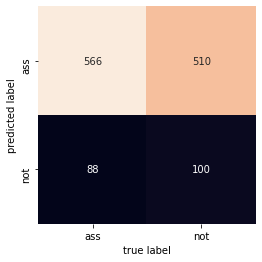

In [144]:
categories = ['ass', 'not']
mat = confusion_matrix(y_test, y_pred_class)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=categories, yticklabels=categories)
plt.xlabel('true label')
plt.ylabel('predicted label')

Well, that doesn't work very well!

### OPTIONAL: Classification using logistic regression

Our predictions are not particularly accurate. This is no surprise, as it would be quite a feat to predict this class based on word usage alone! If you'd want to pursue this hypothesis further, you could try to take more features for X into account. 

Just for fun, let's try comparing this result to **logistic regression**, which is also often used for classification problems. Logistic regression tries to find the optimal decision boundary that best separates classes.

The difference between Naive Bayes and Logistic regression is that the first is a generative model, and the second a discriminative model. What does this mean?
- **Generative model**: Naive Bayes models the joint distribution of the feature X and target y, and then *predicts* the posterior probability given as P(y|X)
- **Discriminative model**: Logistic regression *directly models* the posterior probability of P(y|X) by learning the input to output mapping and minimizing the error.

Unlike Naive Bayes, logistic regression typically works reasonably well even when some of the features (in our case, words) are correlated. This is why it can be a good idea to try both when dealing with texts (because certain words *do* tend to appear in each other's vicinity!).

In [145]:
# instantiate a logistic regression model
logreg = LogisticRegression()

In [146]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 391 ms, sys: 237 ms, total: 629 ms
Wall time: 335 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [147]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [148]:
# calculate predicted probabilities for X_test_dtm
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.43212744, 0.50684742, 0.37648649, ..., 0.65012314, 0.51285732,
       0.54861956])

In [149]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.5411392405063291

Still no good – but you get the idea.

### Improving the model

If you'd want to improve upon this model, you could try to extract other features from the text (for instance, based on the presence of certain words, sentence length, etc.). You could also start looking into other features from the metadata (e.g. the score it received) to improve the prediction – though this is beyond the scope of this notebook.

What you need to know is that this process is called **feature engineering**: taking whatever information you have about your problem and turning it into numbers that you can use to build your feature matrix.

Plugging other features into a classifier could potentially make it more accurate. For now, we can say that we cannot really tell the label based only on the words that people use in their posts.

### Finding the most distinctive terms

Before we move on, let's explore why we would want an accurate model in the first place! For one, this would allow us to calculate the approximate "assholishness" of each token.

In [150]:
# store the vocabulary of X_train
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)

15934

In [153]:
# examine some tokens
print(X_train_tokens[100:150])

['account', 'accountability', 'accountable', 'accountant', 'accounting', 'accredit', 'accross', 'accrue', 'accumulate', 'accumulation', 'accurate', 'accurately', 'accusation', 'accusatory', 'accuse', 'accused', 'accustom', 'accustomed', 'ace', 'acedemy', 'ache', 'achievable', 'achieve', 'achievement', 'achievment', 'achondroplastic', 'achss', 'acid', 'acknowledge', 'acknowledgement', 'acknowledgment', 'acnl', 'acount', 'acoustic', 'acquaint', 'acquaintance', 'acquainted', 'acquantence', 'acquire', 'acquisition', 'acre', 'acrimonious', 'acrobatic', 'acronym', 'across', 'acrylic', 'act', 'acting', 'action', 'activally']


Naive Bayes counts the number of times each token appears in each class. We can access the array of that count by running the `.feature_count_` method.


In [154]:
# note that the trailing underscore often acts to avoid naming errors
nb.feature_count_ 

array([[0.08217246, 0.06929399, 0.29307101, ..., 0.17275316, 0.56178693,
        0.20103568],
       [0.        , 0.        , 0.        , ..., 0.22001616, 0.20061056,
        0.        ]])

What are we seeing here? The rows represent our classes (asshole / not an asshole), the columns represent our tokens (our total vocabulary).


In [155]:
# rows represent classes, columns represent tokens
nb.feature_count_.shape

(2, 15934)

In [ ]:
# number of times each token appears across all ASS posts
ass_token_count = nb.feature_count_[0, :]
ass_token_count

array([0.08217246, 0.06929399, 0.29307101, ..., 0.17275316, 0.56178693,
       0.20103568])

In [158]:
# number of times each token appears across all NOT posts
not_token_count = nb.feature_count_[1, :]
not_token_count

array([0.        , 0.        , 0.        , ..., 0.22001616, 0.20061056,
       0.        ])

We can now create a DataFrame of tokens with their separate ASS and NOT counts.

In [162]:
tokens = pd.DataFrame({'token':X_train_tokens, 'ass':ass_token_count, 'not':not_token_count}).set_index('token')
tokens[110:120] # just a random slice

,ass,not
token,,
accurate,0.454172,0.141095
accurately,0.186609,0.217066
accusation,0.735965,0.519482
accusatory,0.000000,0.421599
accuse,4.242511,5.024768
accused,0.090578,0.000000
accustom,0.000000,0.152566
accustomed,0.085921,0.000000
ace,0.000000,0.087371


Using `.class_count_`, we can count the number of observations in each class

In [164]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([2698., 2355.])

In [165]:
# add 1 to 'ass' and 'not' counts to avoid dividing by 0
tokens['ass'] = tokens['ass'] + 1
tokens['not'] = tokens['not'] + 1
tokens.sample(5, random_state=6)

,ass,not
token,,
undergo,1.000000,1.332385
meth,1.034969,2.133004
physique,1.412383,1.174831
cheeseburger,1.000000,1.219543
baptism,1.116484,1.000000


In [166]:
# convert the 'ass' and 'not' counts into frequencies
tokens['ass'] = tokens['ass'] / nb.class_count_[0]
tokens['not'] = tokens['not'] / nb.class_count_[1]
tokens.sample(5, random_state=6)

,ass,not
token,,
undergo,0.000371,0.000566
meth,0.000384,0.000906
physique,0.000523,0.000499
cheeseburger,0.000371,0.000518
baptism,0.000414,0.000425


In [167]:
# calculate the ratio of ass-to-not for each token
tokens['ass_ratio'] = tokens['ass'] / tokens['not']
tokens.sample(5, random_state=6)

,ass,not,ass_ratio
token,,,
undergo,0.000371,0.000566,0.655118
meth,0.000384,0.000906,0.423531
physique,0.000523,0.000499,1.049364
cheeseburger,0.000371,0.000518,0.715734
baptism,0.000414,0.000425,0.974544


Finally, we can examine the DataFrame sorted by ass_ratio. These are the words, according to our classifier, that are the most typical of "assholeish" posts. A well-working classifier would yield interesting info here on how telling each word is for being considered an asshole by the community. But then again, creating such a classifier is not a trivial matter.  


In [168]:
# note: use sort() instead of sort_values() for pandas 0.16.2 and earlier
tokens.sort_values('ass_ratio', ascending=False)[:10]

,ass,not,ass_ratio
token,,,
tree,0.001823,0.000669,2.724631
explanatory,0.001142,0.000425,2.690329
merge,0.001093,0.000425,2.574841
cent,0.001177,0.000465,2.530000
lawn,0.001720,0.000712,2.416422
overweight,0.001390,0.000583,2.383172
microwave,0.001036,0.000446,2.322403
drill,0.001137,0.000491,2.316760
porn,0.001629,0.000705,2.311076


In [169]:
# look up the not_ratio for a given token
tokens.loc['me', 'ass_ratio']

0.8006683382302092

Looks like the word 'me' occurs 3 as often for people who are classified as assholes (according to our very imprecise classifier at least). With a precise classifier, this would be a very interesting result!

### Training for more classes

We've trained for 2 classes now (asshole and non-asshole), but the posts in this subreddit (as well as many others) actually have more labels, called **flair**. We can find them here under the `flair_text` category.

In [171]:
df.flair_text.unique()[:100]

array(['Everyone Sucks', 'asshole', 'Asshole', 'Tactless!',
       ' UnanimASSly the Asshole', 'Lesser Asshole', 'kinda',
       ' The pizza is the asshole', 'teenager', 'Asshole kinda',
       'assho-ho-ho', 'MetaAsshole', 'assholish', 'dingus', '8 assholes!',
       'asshole (Kind of)', 'shallow', 'everyone sucks',
       'obvious asshole', 'asshole/not a-hole', 'NTA / YTA', 'kind of',
       'asshole (a bit)', 'total asshole', 'All assholes',
       'asshole (Kinda)', 'asshole, kinda', 'asshole (tiny bit)',
       'Both are Assholes', 'asshole, maybe?', 'Huge asshole',
       'communicate', 'Troll', 'slightly', 'Shitpost', '10% asshole',
       '20% asshole', 'OP is an asshole', 'de minimis assholery',
       'tentative', 'Nobody cares :(', 'asshole, say hi',
       'asshole (or young)', 'silent asshole', '(Accidental) Asshole',
       'meta-asshole', 'Mild Asshole', 'huge asshole', 'colossal asshole',
       '1/3 asshole', 'Um...What?', 'low key', '50/50', 'Meta',
       'potential

Quite a lot of categories, turns out. Let's see what the most-frequent categories are, as well as their counts:

In [172]:
df['flair_text'].value_counts()

not the a-hole        1738
asshole               1729
Asshole               1151
Not the A-hole         761
not the asshole        388
                      ... 
OP trolling              1
wow.                     1
assholish                1
of course not            1
potential homocide       1
Name: flair_text, Length: 276, dtype: int64

There are a bunch of categories which we could concatenate in order to work with more data. This might make our classifier more accurate! For now, let's move on.

## Automated sentiment analysis using NLTK VADER

The second half of this notebook is about sentiment analysis (sometimes known as "opinion mining"). The most common use of sentiment analysis is to classify a text into a class (called "sentiment classification"). We'll get to that further on. First, let's see how sentiment analysis itself works.

The simplest option is to use pre-built libraries for sentiment analysis. TextBlob and NLTK VADER are two examples of such libraties. VADER (Valence Aware Dictionary and sEntiment Reasoner) is specifically built for social media texts, and takes multiple text features into account, such as:

- **Punctuation** (e.g. an exclamation mark "!" increases the magnitude of intensity)
- **Capitalization** (e.g. "The food here is GREAT" is more intense than "The food here is great")
- **Degree modifiers** (e.g. "The service here is extremely good" is more intense than "The service here is good")
- **Conjunctions** signal a shift in sentiment polarity, with the sentiment of the text following the conjunction being dominant (e.g. “The food here is great, but the service is horrible”)
- **Preceding Tri-grams** of a sentiment-laden lexical feature catch 90% of cases where negation flips the polarity of the text (e.g. "The food here isn’t really all that great”)
- **Emoji, emoticons & slang** are parsed very well by VADER.

In [173]:
# instantiate Class
analyser = SentimentIntensityAnalyzer()

In [177]:
# a small test
analyser.polarity_scores("""This is really dumb. I don't want to use this stupid 
                          program.""")

{'compound': -0.8323, 'neg': 0.495, 'neu': 0.505, 'pos': 0.0}

VADER spits out several metrics we can use. The **Positive**, **Negative** and **Neutral** scores represent the proportion of text that falls in these categories. This means our sentence was rated as 35% Positive, 50% Neutral and 15% Negative. All these add up to 1.

The **Compound** score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1 (most extreme negative) and +1 (most extreme positive). The compound score turns out to be 0.61: a pretty positive sentiment overall. Let's use that score for now (but be aware that you can use these `neg`, `neu` and `pos` scores to your advantage to train a more precise classifier!)

Now let's write a function that takes a text in, and spits out one of 3 tags based on the compound score, as well as that compound score.

In [178]:
def sentiment_analyzer_scores(text):
    sentiment_dict = analyser.polarity_scores(text)
    # decide sentiment as positive, negative and neutral 
    if sentiment_dict['compound'] >= 0.01 : 
        tag = "pos"
    elif sentiment_dict['compound'] <= - 0.01 : 
        tag = "neg"
    else : 
        tag = "neut" 
    return [tag, sentiment_dict['compound']]

Let's append the output to 2 new columns in our dataframe. `.apply()` allows us to apply a function along an axis of the DataFrame. Also note the use of `zip()` here, allowing us to map the 2 returned values of our function to the tuple of variables we assign them to. Finally, note the `*` to unpack these containers.

In [179]:
df["sent"], df["sent_compound"] = zip(*df.selftext_clean.apply(sentiment_analyzer_scores))

Let's have a look:

In [180]:
df.sent.value_counts()

pos     3404
neg     2860
neut      53
Name: sent, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9cb6a477b8>]],
      dtype=object)

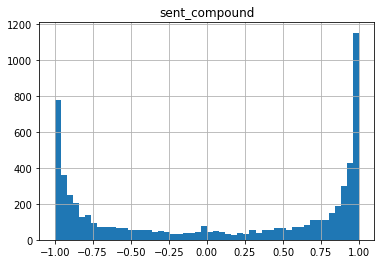

In [181]:
df.hist(column="sent_compound",bins=50)

Let's see if these scores make sense. We'll print out the comment with the highest score (note: we could also use `.idxmax()` to find the comment with the highest score). 

In [184]:
min_id = df.sent_compound.idxmin()
df.selftext_clean[min_id]

'Buckle up folks because this is a long one. So about and a half years ago I reconnected with a girl I met online from canada that really seemed to click with me we shared alot of personal interests links etc. She was in this on off thing with another guy and living with an abusive father. She sends me a nude which causes the on off guy to flip out on me over Skype and I not wanting drama backed off for awhile but something about her hooked me like a drug. We start talking again and she says she wants to be with me and builds up the idea of a dream future. I m into it naturally but she seems really avoidant of making our status known to anyone which is fine shes got that weird ex right So I message a mutual friend and he blows up and starts a shitstorm of drama because she was evidently sexting him the ex and making plans with me. I have alot of drama in the place I m living at the time and see red flags so I deuce and end up in another relationship that I rapidly lose interest in but 

That does look like a comment with lots of negative language.

### Optional assignment: working with sentiment scores

You could use these sentiment scores for all kinds of purposes. 

First, you could look at comments with a high or low sentiment, and see what kinds of topics or concerns are discussed. 

You could train a Naive Bayes classifier (using the code we used above) to see whether sentiments in the posts tell you anything about what `flair_text` class that post falls under. You could also run a **regression analysis** to see if a post's sentiment score (X) is a predictor for something like the user score it received (y). Please see the additional notebook, I will share, "5-X Regression", if you're interested in that.

You could also combine it with your **topic modeling** output, if that output is interesting. You could create a column in your DataFrame that tells you the most-associated topic with each post/comment (using the notebook from week 3), then see if certain topics relate to certain sentiments.

## Training a sentiment analyzer using Naive Bayes

The problem with unsupervised approaches such as the one above is that they typically have poor performance compared to a supervised approach, where we create the labels ourselves.

Let's implement a Naive Bayes Classifier, based on our own sentiment labels. These labels will be based on **whether a commenter evaluates a post positively or negatively**. This requires a training set of samples which have known features and known classes. We can manually label a subset of our comments as positive or negative to form our training set. We will also use a different feature extraction technique this time (rather than using tfidf counts).

So we need to:

1. Create our own sentiment labels for part of our dataset, based on clear rules;
2. Apply feature extraction techniques;
3. Train a classifier for those labels, which we'll base on feature extraction.

In [209]:
downloaded = drive.CreateFile({'id':"1-LYy48UhoADWLlZKteH9zQT2myxQLiDC"})   
downloaded.GetContentFile('amita-comments_small.csv')

In [210]:
# load into df
df_com = pd.read_csv("amita-comments_small.csv", lineterminator='\n')

In [211]:
# Get rid of empty values and reset index
df_com = df_com[~df_com['body'].isin(['[removed]', '[deleted]' ])].dropna(subset=['body']).reset_index(drop=True)
len(df_com)

506001

Let's start labeling ourselves. If you want to be able to classify with some accuracy, you should do **at least a few thousand (!) posts or comments**. This'll take a couple of hours. But you'll have a labeled dataset you can use for all kinds of things!

In [212]:
df_com_labeled = df_com.iloc[1:1000]

In [213]:
df_com_labeled[:5]

,Unnamed: 0,idint,idstr,created,author,parent,submission,body,score,subreddit,distinguish,textlen
1,3000001,31784940951,t1_elnxlef,1556120493,NotAllThere_67,t1_eln480s,t3_bgmg0t,I agree that he shouldn't have reacted that wa...,2,AmItheAsshole,NaN,192
2,3000002,31784941007,t1_elnxlfz,1556120494,AutoModerator,t3_bgw50s,t3_bgw50s,^^^^AUTOMOD ***The following is a copy of the...,1,AmItheAsshole,moderator,876
3,3000003,31784941015,t1_elnxlg7,1556120494,nuclearwinterxxx,t3_bgqjrp,t3_bgqjrp,"NTA, what is this, high school? That's just so...",1,AmItheAsshole,NaN,144
4,3000004,31784941022,t1_elnxlge,1556120494,AutoModerator,t3_bgw50s,t3_bgw50s,\nIf you want your comment to count toward jud...,1,AmItheAsshole,moderator,822
5,3000005,31784941178,t1_elnxlkq,1556120497,illini02,t1_elnw2bs,t3_bgndwy,"Ok, cool. Thanks for the clarification. So t...",1,AmItheAsshole,NaN,356


Now, we'll loop over the rows and display the post for each row, and ask the user to label it

In [214]:
# Classifications:
# p: overall positive evaluation of OP
# n: overall negative evaluation of OP
# x: cannot determine evaluation of OP, or comment is made by OP

for index, row in df_com_labeled.iterrows():
    print(row.body)
    df_com_labeled.loc[index, 'sentiment'] = input()
    clear_output()

I agree that he shouldn't have reacted that way. My judgement is definitely ESH. 

But she is more of an asshole, imo.
She was way out of line, *especially* given the difficulty they have had.


KeyboardInterrupt: ignored

In [215]:
df_com_labeled[:5]

,Unnamed: 0,idint,idstr,created,author,parent,submission,body,score,subreddit,distinguish,textlen
1,3000001,31784940951,t1_elnxlef,1556120493,NotAllThere_67,t1_eln480s,t3_bgmg0t,I agree that he shouldn't have reacted that wa...,2,AmItheAsshole,NaN,192
2,3000002,31784941007,t1_elnxlfz,1556120494,AutoModerator,t3_bgw50s,t3_bgw50s,^^^^AUTOMOD ***The following is a copy of the...,1,AmItheAsshole,moderator,876
3,3000003,31784941015,t1_elnxlg7,1556120494,nuclearwinterxxx,t3_bgqjrp,t3_bgqjrp,"NTA, what is this, high school? That's just so...",1,AmItheAsshole,NaN,144
4,3000004,31784941022,t1_elnxlge,1556120494,AutoModerator,t3_bgw50s,t3_bgw50s,\nIf you want your comment to count toward jud...,1,AmItheAsshole,moderator,822
5,3000005,31784941178,t1_elnxlkq,1556120497,illini02,t1_elnw2bs,t3_bgndwy,"Ok, cool. Thanks for the clarification. So t...",1,AmItheAsshole,NaN,356


In [ ]:
# save your labels to csv
df_com_labeled.to_csv('df_com_Sentiment_Labeled.csv')

(I've cheated here and randomly assigned some tags to the corpus in the cell below, just so you can see how this works)

In [222]:
tags = ['p', 'n', 'x']
df_com_labeled["sentiment"] = np.random.choice(tags, 999, p=[0.3, 0.6, 0.1])

In [223]:
df_com_labeled = df_com_labeled.reset_index(drop=True)

### Train, test, and cross-validation sets

When building our sentiment analyzer, we need to create a test set again, in order to prevent overestimating its performance and overconstraining it. We will use the test set to evaluate the performance of our sentiment analyzer once it is complete.

When designing our sentiment analyzer, we’ll have a number of choices to make along the way (which were made for us when using VADER). How many features should we use? Should we include the capitalization of words as a feature?  All of these **hyperparameters** will effect the performance of our sentiment analyzer. To maximize performance, it's best to evaluate our classifier under different hyperparameter settings. We could do this with the training set itself – but then we run into the same risk of overconstraining the analyzer that we discussed earlier. Using the test set would mean we'd be tuning our classifier to the test set – defeating the purpose of setting that data aside in the first place.

So we'll set another portion of the original training set aside: the **cross-validation** set. We can use it to evaluate the performance of our sentiment analyzer as we tune our hyperparameters. This means the final evaluation of our analyzer’s performance will be a true representation of how it will perform on unlabeled comments from our full collection.

First, let's have a look at how much we've done

In [224]:
pos_comments = [(df_com_labeled.loc[row,'body'],'positive') for row in range(len(df_com_labeled)) if 
              df_com_labeled.loc[row,'sentiment'] == 'p']

neg_comments = [(df_com_labeled.loc[row,'body'],'negative') for row in range(len(df_com_labeled)) if 
              df_com_labeled.loc[row,'sentiment'] == 'n']

print('Number of comments labeled positive: %d' % len(pos_comments))
print('Number of comments labeled negative: %d' % len(neg_comments))

Number of comments labeled positive: 316
Number of comments labeled negative: 585


Note that you see a class imbalance here – we have way more negative than positive labels. This presents a new challenge for our sentiment analyzer. If the probability of seeing positive comments is small, Bayes Theorem is likely to predict that the probability of any comment being positive is small **regardless of the evidence**. So we need to up- or downsample again.

The choice of upsampling, downsampling, or randomly sampling (producing the true positive to negative ratio) is a **hyperparameter** of our sentiment analyzer. To know which method will work best, we ought to try all of them and see which yields the best performance on your cross-validation set. 

For now, we will put half of the positive and negative comments into the **training set** while down sampling negative tweets at a one-to-one ratio. Half of the remaining comments will go into the **cross-validation set**, and the final quarter of comments into the **test set**.

In [226]:
# Half of the positive comments go in training
# Downsampling the negative comments at 1 pos:1 neg

len_train = int(round(len(pos_comments)/2)*2) # Define total len of train set based on len of pos_comments
train_comments = pos_comments[:int(len_train/2)] + neg_comments[:int(len_train/2)]

# Half of the remaining half go in cv
cv_neg_cutoff = int((len_train/2) + round((len(neg_comments) - len_train/2)/2))
cv_pos_cutoff = int((len_train/2) + round((len(pos_comments) - len_train/2)/2))
cv_comments = neg_comments[int(len_train/2):cv_neg_cutoff] + pos_comments[int(len_train/2):cv_pos_cutoff]  

# Rest go into testing
test_comments = neg_comments[cv_neg_cutoff:] + pos_comments[cv_pos_cutoff:]  

In [227]:
## Test
train_comments[7]

('How is the fear irrational if there was an actual active shooter in the area? Yes the shooter was caught but it still happened. An irrational fear would need to be completely baseless and unlikely.',
 'positive')

(Note that you can do this kind of splitting through scikit-learn's `train_test_split()` and `KFold()` methods, making it much easier!)

## Feature extraction design

Now it's time to define our sentiment analyzer’s features. We'll do so with boolean `contains(word)` statements. For instance, the feature `contains(disagree)` will likely be `True` for a negative comment, and `False` for a positive tweet. We’ll need to construct a list of useful words for this purpose.

### Bigrams
Note that this is harder than it might seem! If we were to train a model that believes the word “like” indicates a positive tweet, we would misclassify the second tweet. It’s clear that the classifier’s performance would increase if it could recognize that the word “not” is negating the word “like.” One way to address negation markers is to include **bigrams** in our list of features. Doing so allows our classifier to recognize the collocation of words such as “(not,like)” in addition to the typical unigram features we would extract.

### Preventing overfit
This word list shouldn’t include every word we come across in our collection of comments: using too many uncommon words will cause our sentiment analyzer to *overfit* the training sample. This usually happens when the model is too complex (that is, using too many features compared to the number of observations). Such a model will be very accurate on the training data  not accurate on untrained or new data. 

We will avoid this issue by requiring that each word **appear a certain number of times** before we consider it as a feature. 

Let's write a function that applies these feature extraction techniques to our comments. First, we extract a list of unigrams and bigrams. We treat all html URLs as the same “word”, while excluding punctuation and capitalization.

In [236]:
from nltk.metrics import BigramAssocMeasures
from nltk.collocations import BigramCollocationFinder
import string
import itertools
from gensim.utils import simple_preprocess

punct = set(string.punctuation)

def filter_comments(comments):
    filtered_bigrams = []
    for words, sentiment in comments: 
        words_filtered = []
        # Lemmatize using spacy
        words = words.lower()
        doc = simple_preprocess(str(words), deacc=True)     
        words_filtered.extend([token for token in doc])
        # Identify top 200 bigams using chi_sq measure of importance
        bigram_finder = BigramCollocationFinder.from_words(words_filtered)
        bigrams = bigram_finder.nbest(BigramAssocMeasures.chi_sq, 200)      
        # Add to filtered list
        filtered_bigrams.append(([ngram for ngram in itertools.chain(words_filtered,bigrams)],sentiment))
    return filtered_bigrams

The result of the filter is a **list of tuples** for each comment. The first entry in each tuple is a list of unigrams and bigrams for that comment, and the second entry in the tuple is the manually labeled sentiment of that comment.

In [237]:
train_tuples = filter_comments(train_comments)
cv_tuples = filter_comments(cv_comments)
test_tuples = filter_comments(test_comments)    

In [238]:
train_tuples[0]

(['agree',
  'that',
  'he',
  'shouldn',
  'have',
  'reacted',
  'that',
  'way',
  'my',
  'judgement',
  'is',
  'definitely',
  'esh',
  'but',
  'she',
  'is',
  'more',
  'of',
  'an',
  'asshole',
  'imo',
  'she',
  'was',
  'way',
  'out',
  'of',
  'line',
  'especially',
  'given',
  'the',
  'difficulty',
  'they',
  'have',
  'had',
  ('an', 'asshole'),
  ('asshole', 'imo'),
  ('definitely', 'esh'),
  ('difficulty', 'they'),
  ('esh', 'but'),
  ('especially', 'given'),
  ('given', 'the'),
  ('he', 'shouldn'),
  ('line', 'especially'),
  ('my', 'judgement'),
  ('the', 'difficulty'),
  ('agree', 'that'),
  ('but', 'she'),
  ('have', 'had'),
  ('have', 'reacted'),
  ('imo', 'she'),
  ('is', 'definitely'),
  ('is', 'more'),
  ('judgement', 'is'),
  ('more', 'of'),
  ('of', 'an'),
  ('of', 'line'),
  ('out', 'of'),
  ('reacted', 'that'),
  ('she', 'was'),
  ('shouldn', 'have'),
  ('that', 'he'),
  ('they', 'have'),
  ('was', 'way'),
  ('way', 'my'),
  ('way', 'out'),
  ('she',

Remember that we wanted to get rid of the features that do not appear frequently? We'll now remove all unigrams or bigrams that appear less than 3 times.

In [239]:
def get_word_features(comments,min_freq):
    word_list = []
    for word_or_tuple in comments:
        word_list.extend(word_or_tuple[0])
    # Count the frequency of each unigram and bigram
    freqs = FreqDist(word_list)
    # Sort based on frequency
    sorted_word_list = sorted(freqs.items(), key=lambda x: x[1], reverse=True)
    # Only include features appearing at least min_freq times
    word_features = [sorted_word_list[word][0] for word in 
                     range(len(sorted_word_list)) if sorted_word_list[word][1] >= min_freq]    
    # Return list of features
    return word_features

word_features = get_word_features(train_tuples, 3)

Let's see how many features we have found!

In [240]:
len(word_features)

1534

Now that we have a final list of word features, we can finally evaluate the boolean `contains(word_feature)` statements for each tweet. To do so, we first define an `extract_features()` function that takes a filtered comment as an input, then determines if each word feature exists in the filtered comment’s list of unigrams and bigrams.

In [241]:
def extract_features(filtered_comment):
    filtered_comment_words = set(filtered_comment)
    features = {}
    for word in word_features:        
        # Check if word feature is present in filtered_comment
        features['contains(%s)' % str(word)] = (word in filtered_comment_words)
    return features

The NLTK classify package provides a convenient `.apply_features()` method to apply our `extract_features()` function to each comment in our datasets:

In [242]:
training_set = apply_features(extract_features, train_tuples)
cv_set = apply_features(extract_features, cv_tuples)
test_set = apply_features(extract_features, test_tuples)

The final result is a NLTK `LazyMap` object that contains a tuple for each comment. The first entry in the tuple is a list of boolean `contains(word)` features for each of the feature words we selected, while the second entry in the tuple is the manually labeled sentiment of the comment.

In [ ]:
training_set[0][0]

## Training the classifier

It's Time to train our Naive Bayes Classifier. Let's use NLTK's one this time around.

Note that we're using Bayesian classfier over **binary features** this time: that is, we use a bunch of boolean `contains()` variables that tell our classifier whether or not some feature is present in a comment. The equivalent in sklearn for this is the `BernoulliNB` classifier.

In [244]:
classifier = NaiveBayesClassifier.train(training_set)

### Evaluation

To accurately evaluate the performance of our classifier, we have to look at 2 things: **precision** and **recall**.

- **Precision:** the number of true positives (correctly labeled items) divided by the sum of true positives and false positives (incorrectly labeled items)
- **Recall:** the number of true positives divided by the total number of elements that actually belong to the positive class (i.e., the sum of true positives and false negatives).

We can average the precision and recall metrics using their harmonic mean, producing a quantity known as the F1 score. It's a measure of a test's total accuracy. See https://en.wikipedia.org/wiki/F1_score for more.

We'll use a function that evaluates our classifier, based on the cross-validation set we created earlier. We'll calculate F1, precision and recall scores.

In [245]:
def eval_classifier(data_set):
    # NLTK .accuracy method calculates accuracy
    cross_valid_accuracy = accuracy(classifier, data_set)

    # Create two sets to count positive and negative comments
    ref_set = collections.defaultdict(set)
    obs_set = collections.defaultdict(set)

    # Loop over each comment in our cross validation set
    for i, (feats, label) in enumerate(data_set):

        #Classify the comment by feeding the classifier the comment's features
        observed = classifier.classify(feats)

        #Add the current comment to the "reference" set under the actual class
        ref_set[label].add(i)

        #Add the current coment to the "observation" set under the predicted class
        obs_set[observed].add(i)

    # Calculate F score, precision, an recall for positive and negative labels
    print ('Accuracy:', cross_valid_accuracy)
    print ('F-measure [negative]:', fmeas(ref_set['negative'], obs_set['negative']))
    print ('F-measure [positive]:', fmeas(ref_set['positive'], obs_set['positive']))
    print ('Precision [negative]:', prec(ref_set['negative'], obs_set['negative']))
    print ('Precision [positive]:', prec(ref_set['positive'], obs_set['positive']))
    rec_neg=rec(ref_set['negative'], obs_set['negative'])
    rec_pos=rec(ref_set['positive'], obs_set['positive'])
    print ('Recall [negative]:', rec_neg)
    print ('Recall [positive]:', rec_pos)
    total_neg=len(neg_comments)
    total_pos=len(pos_comments)

In [246]:
eval_classifier(cv_set) 

Accuracy: 0.4232081911262799
F-measure [negative]: 0.46006389776357826
F-measure [positive]: 0.38095238095238093
Precision [negative]: 0.7272727272727273
Precision [positive]: 0.26804123711340205
Recall [negative]: 0.3364485981308411
Recall [positive]: 0.6582278481012658


At this point, we have to see if we are happy with the outcome of our performance metrics. 
If not, we need to change the hyperparameters of our classifier and revaluate its performance on our cross-validation set. As noted, we may want to consider limiting our classifier to **high-information features**. We can check what these features are using NLTK’s `show_most_informative_features()` method.

In [247]:
print(classifier.show_most_informative_features(5))

Most Informative Features
 contains(('of', 'you')) = True           positi : negati =      5.7 : 1.0
           contains(dad) = True           negati : positi =      5.7 : 1.0
     contains(situation) = True           negati : positi =      5.0 : 1.0
         contains(these) = True           negati : positi =      5.0 : 1.0
         contains(often) = True           negati : positi =      5.0 : 1.0
None


We can use these features in the *feature extraction design* step above to see if it will improve our model (which it won't necessarily will). **The goal is, through tweaking our hyperparameters like this, to improve the accuracy of our model.** 

### Evaluating on the test set

It's only after tweaking our model for a while that we should crack open our test set and see how well our classifier has done!

In [248]:
eval_classifier(test_set)

Accuracy: 0.4246575342465753
F-measure [negative]: 0.4473684210526316
F-measure [positive]: 0.4
Precision [negative]: 0.7472527472527473
Precision [positive]: 0.27860696517412936
Recall [negative]: 0.3192488262910798
Recall [positive]: 0.7088607594936709


## Conclusion: Data analysis and hermeneutics

That was a lot! Again, don't worry if you didn't understand every part of this notebook. Its main purpose is for you to get a first look into the many ways in which data scientists can classify their data.

There's a lot you can do with the methods we've applied here. For instance, you can use classification to try and find binaries in your dataset. You could tag a corpus manually, based on the presence of some binary category X or Y that you deem important. You could also create a set of categories based on, say, particular word frequencies. Then you can create a classifier to see if you can successfully predict these categories in other texts.

You can use classification, feature extraction and sentiment analysis to explore your own data. For instance:
- Using sentiment scores to trace posts or topics of interest;
- Using feature extraction to create new classes; 
- Training a classifier based on your own classes (e.g. the presence of a specific topic you're interested in).